# Sampler statistics

When checking for convergence or when debugging a badly behaving
sampler, it is often helpful to take a closer look at what the
sampler is doing. For this purpose some samplers export
statistics for each generated sample.

In [78]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import xarray as xr

%matplotlib inline

print(f"Runing on PyMC3 v{pm.__version__}")

Runing on PyMC3 v3.11.2


In [79]:
az.style.use("arviz-darkgrid")

As a minimal example we sample from a standard normal distribution:

In [80]:
model = pm.Model()
with model:
    mu1 = pm.Normal("mu1", mu=0, sigma=1, shape=10)

In [81]:
with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 9 seconds.


NUTS provides the following statistics:

In [82]:
trace.sample_stats.data_vars

Data variables: (12/13)
    perf_counter_start  (chain, draw) float64 1.594e+03 1.594e+03 ... 1.596e+03
    lp                  (chain, draw) float64 -13.13 -13.67 ... -15.77 -14.19
    diverging           (chain, draw) bool False False False ... False False
    max_energy_error    (chain, draw) float64 -0.4791 0.4339 ... 0.8172 -0.4252
    step_size_bar       (chain, draw) float64 0.9529 0.9529 ... 0.9093 0.9093
    acceptance_rate     (chain, draw) float64 0.9819 0.8846 ... 0.6049 1.0
    ...                  ...
    process_time_diff   (chain, draw) float64 0.00057 0.00031 ... 0.000412
    perf_counter_diff   (chain, draw) float64 0.00057 0.0003091 ... 0.0004153
    tree_depth          (chain, draw) int64 3 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2
    step_size           (chain, draw) float64 0.8548 0.8548 ... 0.852 0.852
    n_steps             (chain, draw) float64 7.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
    energy_error        (chain, draw) float64 -0.3426 0.125 ... 0.7733 -0.3769

[Arviz](https://arviz-devs.github.io/arviz/schema/schema.html#sample-stats) follows the following Name Convention for sample_stats variables:

- `lp`: The joint log posterior density for the model (up to an additive constant).

- `acceptance_rate`: The average acceptance probabilities of all possible samples in the proposed tree.

- `step_size`: The current integration step size.

- `step_size_nom`: The nominal integration step size. The `step_size` may differ from this, for example if the step size is jittered. Should only be present if `step_size` is also present and it varies between samples (i.e. step size is jittered).

- `tree_depth`: The number of tree doublings in the balanced binary tree.

- `n_steps`: The number of leapfrog steps computed. It is related to `tree_depth` with `n_steps <= 2^tree_dept`.

- `diverging`: (boolean) Indicates the presence of leapfrog transitions with large energy deviation from starting and subsequent termination of the trajectory. “large” is defined as `max_energy_error` going over a threshold.

- `energy`: The value of the Hamiltonian energy for the accepted proposal (up to an additive constant).

- `energy_error`: The difference in the Hamiltonian energy between the initial point and the accepted proposal.

- `max_energy_error`: The maximum absolute difference in Hamiltonian energy between the initial point and all possible samples in the proposed tree.

- `int_time`: The total integration time (static HMC sampler)



If the name of the statistic does not clash with the name of one of the variables, we can use indexing to get the values. The values for the chains will be concatenated.

We can see that the step sizes converged after the 1000 tuning samples for both chains to about the same value. The first 2000 values are from chain 1, the second 2000 from chain 2.

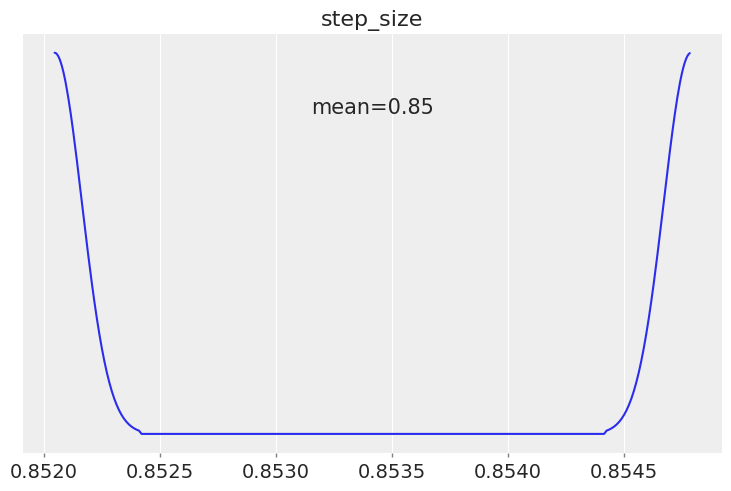

In [83]:
az.plot_posterior(trace, group="sample_stats", var_names="step_size", hdi_prob="hide", kind="kde");

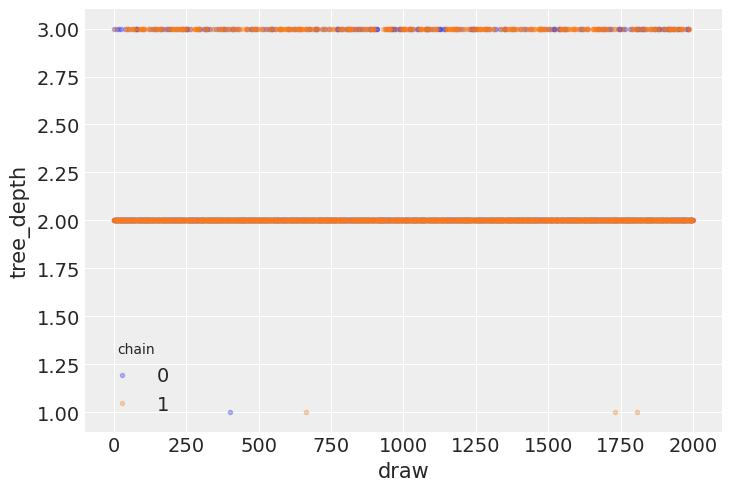

In [84]:
trace.sample_stats["tree_depth"].plot(hue="chain", ls="none", marker=".", alpha=0.3);

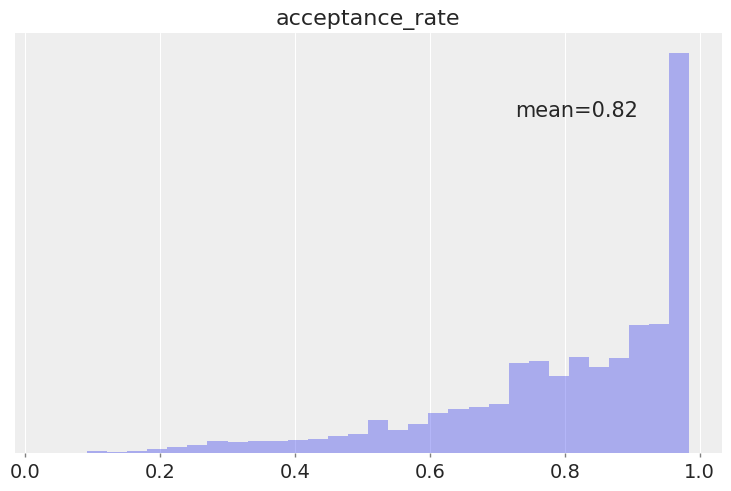

In [85]:
az.plot_posterior(
    trace, group="sample_stats", var_names="acceptance_rate", hdi_prob="hide", kind="hist"
);

Find the index of all diverging transitions:

In [86]:
trace.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In [87]:
trace.posterior.where(trace.sample_stats["diverging"])

<xarray.Dataset>
Dimensions:    (chain: 2, draw: 2000, mu1_dim_0: 10)
Coordinates:
  * chain      (chain) int64 0 1
  * draw       (draw) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
  * mu1_dim_0  (mu1_dim_0) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    mu1        (chain, draw, mu1_dim_0) float64 nan nan nan nan ... nan nan nan
Attributes:
    created_at:                 2021-04-02T19:01:16.089527
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              8.847715854644775
    tuning_steps:               1000

It is often useful to compare the overall distribution of the
energy levels with the change of energy between successive samples.
Ideally, they should be very similar:

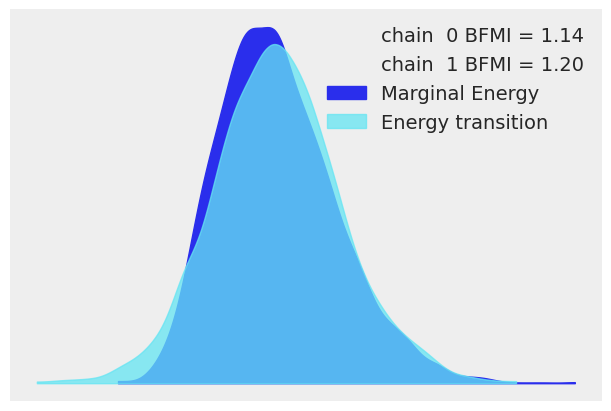

In [88]:
az.plot_energy(trace, figsize=(6, 4));

If the overall distribution of energy levels has longer tails, the efficiency of the sampler will deteriorate quickly.

## Multiple samplers

If multiple samplers are used for the same model (e.g. for continuous and discrete variables), the exported values are merged or stacked along a new axis.

Note that for the `model_logp` sampler statistic, only the last column (i.e. `trace.get_sampler_stat('model_logp')[-1]`) will be the overall model logp.

In [89]:
model = pm.Model()
coords = {"step": ["BinaryMetropolis", "Metropolis"]}
dims = {"accept": ["step"]}

with model:
    mu1 = pm.Bernoulli("mu1", p=0.8)
    mu2 = pm.Normal("mu2", mu=0, sigma=1, shape=10)
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])
    trace = pm.sample(
        10000,
        init=None,
        step=[step1, step2],
        cores=2,
        tune=1000,
        return_inferencedata=True,
        idata_kwargs={"dims": dims, "coords": coords},
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 11 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [90]:
trace.sample_stats.data_vars

Data variables:
    accepted  (chain, draw) bool False False False False ... False False True
    accept    (chain, draw, accept_dim_0) float64 0.25 0.4891 1.0 ... 1.0 2.984
    p_jump    (chain, draw) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5 0.5
    scaling   (chain, draw) float64 0.729 0.729 0.729 ... 0.729 0.729 0.729

Both samplers export `accept`, so we get one acceptance probability for each sampler:

In [92]:
trace.sample_stats["accept"]

<xarray.DataArray 'accept' (chain: 2, draw: 10000, accept_dim_0: 2)>
array([[[2.50000000e-01, 4.89096541e-01],
        [1.00000000e+00, 5.98009353e-02],
        [4.00000000e+00, 8.32488450e-02],
        ...,
        [2.50000000e-01, 1.19740654e-01],
        [1.00000000e+00, 4.83793600e-02],
        [1.00000000e+00, 1.10393484e-01]],

       [[2.50000000e-01, 1.09888343e-05],
        [1.00000000e+00, 3.37071637e-01],
        [1.00000000e+00, 8.57329324e+00],
        ...,
        [1.00000000e+00, 7.96799606e-02],
        [2.50000000e-01, 2.55275918e-04],
        [1.00000000e+00, 2.98391458e+00]]])
Coordinates:
  * chain         (chain) int64 0 1
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * accept_dim_0  (accept_dim_0) int64 0 1

In [93]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Sat Apr 03 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

numpy     : 1.20.1
seaborn   : 0.11.1
matplotlib: 3.3.4
pandas    : 1.2.3
pymc3     : 3.11.2
arviz     : 0.11.2
xarray    : 0.17.0

Watermark: 2.2.0

